In [ ]:
#default_exp modelling.mypvfactors

In [ ]:
#export
from capetools.imports import *
from capetools.utils.tmy import *
import pvfactors
from pvfactors.geometry import OrderedPVArray
from pvfactors.engine import PVEngine
import pvlib

In [ ]:
from nbdev.showdoc import show_doc

# pvfactors
> My custom pvfactors fucntions.

In [ ]:
DATAPATH = Path.cwd().parent/'data'
DATAPATH.ls()

(#2) [Path('/home/tc256760/Documents/capetools/data/pvgis_tmy_chambery.csv'),Path('/home/tc256760/Documents/capetools/data/sample_data.hdf')]

In [ ]:
fname = 'sample_data.hdf'
df = pd.read_hdf(DATAPATH/fname)
df.head()

,ghi,dni,dhi,temp_air,wind_speed,wind_dir,pressure,humidity,zenith,elevation,azimuth
Date UTC,,,,,,,,,,,
2019-01-01 00:00:00,-0.83,0.0,-0.83,4.39,1.87,230.1,1004.92,86.8,157.028814,-67.028814,12.053823
2019-01-01 01:00:00,-0.93,0.0,-0.83,4.33,2.87,228.9,1004.94,86.8,152.142520,-62.142520,42.533373
2019-01-01 02:00:00,-0.83,0.0,-0.83,4.29,2.86,229.4,1004.68,86.7,143.742340,-53.742340,63.390006
2019-01-01 03:00:00,-0.83,0.0,-0.83,4.15,2.04,186.0,1003.99,85.7,133.848157,-43.848157,78.092116
2019-01-01 04:00:00,-0.72,0.0,-0.83,3.85,1.91,200.9,1003.76,87.5,123.435454,-33.435454,89.729489


## Defining the system
To quickly define a system, we create a method that will take care of the right naming and convenctions.

In [ ]:
#export
def system_def(albedo: float=0.4, 
               n_modules_vertically: int=2, 
               module_size: tuple=(1.69,1.01), 
               h_ground: float=1,
               surface_tilt: int=38,
               axis_azimuth: int=0,
               surface_azimuth: int=180,
               n_pvrows: int=1,
               tracking: bool=False,
               gcr: float=0.5):
    "A wrapper function to define the pvfactors pvarray_parameters dictionary"
    w_m, h_m = module_size  #width x height of module
    if not tracking: h_center = h_ground + np.sin(2*np.pi*surface_tilt/360)*h_m
    else: h_center = h_ground
    pvarray_parameters = {
        'n_pvrows': n_pvrows,            # number of pv rows
        'pvrow_height': h_center,        # height of pvrows (measured at center / torque tube)
        'pvrow_width': n_modules_vertically * h_m,         # width of pvrows
        'tracking':tracking,
        'axis_azimuth': axis_azimuth,       # azimuth angle of rotation axis
        'surface_tilt': surface_tilt,      # tilt of the pv rows
        'surface_azimuth': surface_azimuth,   # azimuth of the pv rows front surface
        'albedo':albedo,
        'gcr': gcr,               # ground coverage ratio,
        'rho_front_pvrow': 0.075,  # pv row front surface reflectivity
        'rho_back_pvrow': 0.075,    # pv row back surface reflectivity
        'cut':{
            i: {'front': 1,'back': 7} for i in range(n_pvrows) # discretize the front  PV row into 1 segments and back in 7
    }
    }
    return pvarray_parameters

In [ ]:
pvarray_params = system_def(); pvarray_params

{'n_pvrows': 1,
 'pvrow_height': 1.6218180900789148,
 'pvrow_width': 2.02,
 'tracking': False,
 'axis_azimuth': 0,
 'surface_tilt': 38,
 'surface_azimuth': 180,
 'albedo': 0.4,
 'gcr': 0.5,
 'rho_front_pvrow': 0.075,
 'rho_back_pvrow': 0.075,
 'cut': {0: {'front': 1, 'back': 7}}}

In [ ]:
df

,ghi,dni,dhi,temp_air,wind_speed,wind_dir,pressure,humidity,zenith,elevation,azimuth
Date UTC,,,,,,,,,,,
2019-01-01 00:00:00,-0.83,0.00,-0.83,4.39,1.87,230.10,1004.92,86.8,157.028814,-67.028814,12.053823
2019-01-01 01:00:00,-0.93,0.00,-0.83,4.33,2.87,228.90,1004.94,86.8,152.142520,-62.142520,42.533373
2019-01-01 02:00:00,-0.83,0.00,-0.83,4.29,2.86,229.40,1004.68,86.7,143.742340,-53.742340,63.390006
2019-01-01 03:00:00,-0.83,0.00,-0.83,4.15,2.04,186.00,1003.99,85.7,133.848157,-43.848157,78.092116
2019-01-01 04:00:00,-0.72,0.00,-0.83,3.85,1.91,200.90,1003.76,87.5,123.435454,-33.435454,89.729489
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,-1.36,0.09,-1.36,-0.84,0.78,23.88,1005.05,100.0,120.109907,-30.109907,266.843772
2019-12-31 20:00:00,-1.36,-0.09,-1.48,-0.70,0.16,193.80,1005.08,100.0,130.567903,-40.567903,277.905352
2019-12-31 21:00:00,-1.48,-0.09,-1.63,-1.24,0.42,156.60,1004.99,100.0,140.699448,-50.699448,291.371504


Handy function to get back indxes of dates

In [ ]:
#export
def get_index(df, date): return df.index.get_loc(date)

In [ ]:
date = '12h 21 Jun 2019'
get_index(df, date)

4116

In [ ]:
data_idx = df.loc[date]
data_idx

ghi           388.440000
dni             2.050000
dhi           389.870000
temp_air       25.320000
wind_speed      2.250000
wind_dir       51.160000
pressure      988.020000
humidity       58.770000
zenith         22.637242
elevation      67.362758
azimuth       193.074028
Name: 2019-06-21 12:00:00, dtype: float64

Note that `surface_azimuth` and `surface_tilt` can be variable (i.e. one for each timestep)

In [ ]:
params = {'axis_azimuth': pvarray_params['axis_azimuth'],
         'gcr': pvarray_params['gcr'],
         'n_pvrows': pvarray_params['n_pvrows'],
         'pvrow_height': pvarray_params['pvrow_height'],
         'pvrow_width': pvarray_params['pvrow_width'],
         'solar_azimuth': data_idx['azimuth'],
         'solar_zenith': data_idx['zenith'],
         'surface_azimuth': pvarray_params['surface_azimuth'],
         'surface_tilt': pvarray_params['surface_tilt'],
         'cut':pvarray_params['cut']}

In [ ]:
show_doc(OrderedPVArray)

<h2 id="OrderedPVArray" class="doc_header"><code>class</code> <code>OrderedPVArray</code><a href="pvfactors/geometry/pvarray.py#L12" class="source_link" style="float:right">[source]</a></h2>

> <code>OrderedPVArray</code>(**`axis_azimuth`**=*`None`*, **`gcr`**=*`None`*, **`pvrow_height`**=*`None`*, **`n_pvrows`**=*`None`*, **`pvrow_width`**=*`None`*, **`param_names`**=*`None`*, **`cut`**=*`None`*) :: `BasePVArray`

An ordered PV array has a flat horizontal ground, and pv rows which
are all at the same height, with the same surface tilt and azimuth angles,
and also all equally spaced. These simplifications allow faster and easier
calculations. In the ordered PV array, the list of PV rows must be
ordered from left to right (along the x-axis) in the 2D geometry.

This is like running a simulatino for 1 timestep,
- `pvarray`: It is a structure to hold the parameters and the meteorological info. Can hold full timeseries or just one timestep.

In [ ]:
pvarray = OrderedPVArray.fit_from_dict_of_scalars(params)

It has a handy method to plot at a given timestep:

In [ ]:
show_doc(OrderedPVArray.plot_at_idx)

<h4 id="BasePVArray.plot_at_idx" class="doc_header"><code>BasePVArray.plot_at_idx</code><a href="pvfactors/geometry/base.py#L1177" class="source_link" style="float:right">[source]</a></h4>

> <code>BasePVArray.plot_at_idx</code>(**`idx`**, **`ax`**, **`merge_if_flag_overlap`**=*`True`*, **`with_cut_points`**=*`True`*, **`x_min_max`**=*`None`*, **`with_surface_index`**=*`False`*)

Plot all the PV rows and the ground in the PV array at a desired
step index. This can be called before transforming the array, and
after fitting it.

Parameters
----------
idx : int
    Selected timestep index for plotting the PV array
ax : :py:class:`matplotlib.pyplot.axes` object
    Axes for plotting the PV array geometries
merge_if_flag_overlap : bool, optional
    Decide whether to merge all shadows if they overlap
    (Default = True)
with_cut_points :  bool, optional
    Decide whether to include the saved cut points in the created
    PV ground geometry (Default = True)
x_min_max : tuple, optional
    List of minimum and maximum x coordinates for the flat ground
    surface [m] (Default = None)
with_surface_index : bool, optional
    Plot the surfaces with their index values (Default = False)

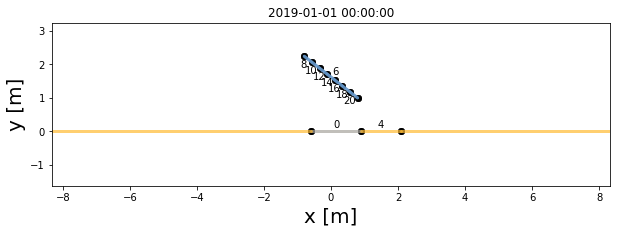

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
pvarray.plot_at_idx(0, ax, with_surface_index=True)
ax.set_title(df.index[0])
plt.show()

this is very useful, so we will wrap it up on a function.

In [ ]:
#export
def plot_idx(pvarray, idx=4550, with_index=False, figsize=(10,3)):
    "Plot a pvarray at idx"
    f, ax = plt.subplots(figsize=figsize)
    pvarray.plot_at_idx(idx, ax, with_surface_index=with_index)
    ax.set_xlim(-5, 5)
    return ax

we will need a fit method together to plot:

In [ ]:
#export
def fit_and_plot(data:DataFrame, pvarray_parameters:dict, date:Union[str, int], with_index:bool=False):
    "Method to debug a pvfactors pvarray, plots the model at idx"
    data_idx = df.loc[date] if type(date) is str else df.iloc[date]
    params = {'axis_azimuth': pvarray_params['axis_azimuth'],
             'gcr': pvarray_params['gcr'],
             'n_pvrows': pvarray_params['n_pvrows'],
             'pvrow_height': pvarray_params['pvrow_height'],
             'pvrow_width': pvarray_params['pvrow_width'],
             'solar_azimuth': data_idx['azimuth'],
             'solar_zenith': data_idx['zenith'],
             'surface_azimuth': pvarray_params['surface_azimuth'],
             'surface_tilt': pvarray_params['surface_tilt'],
             'cut':pvarray_params['cut']}
    pvarray = OrderedPVArray.fit_from_dict_of_scalars(params)
    ax = plot_idx(pvarray, 0, with_index)
    if type(date) is int:
        date = df.index[date]
        date = f'{date.hour}h {date.day} {date.month_name()[0:3]} {date.year}'
    ax.set_title(date)
    return pvarray

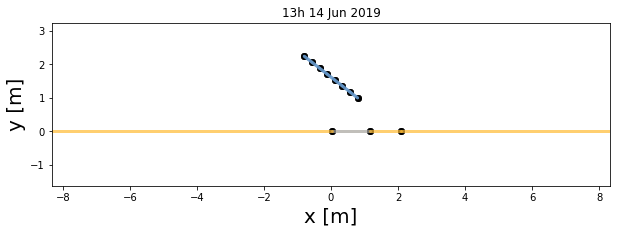

In [ ]:
pvarray = fit_and_plot(df, pvarray_params, '13h 14 Jun 2019')

You can also call it with an index

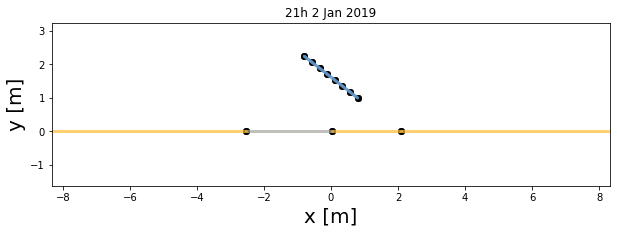

In [ ]:
pvarray = fit_and_plot(df, pvarray_params, 45)

In [ ]:
#export
def join_sun(tmy_data: DataFrame, sunpos:DataFrame, pvarray_params:dict)->DataFrame:
    "Concats meteo data with sunpos"
    data = pd.DataFrame(index=tmy_data.index)
    data['ghi'] = tmy_data.ghi
    data['dni'] = tmy_data.dni
    data['dhi'] = tmy_data.dhi
    data['zenith'] = sunpos.zenith
    data['azimuth'] = sunpos.azimuth
    data['elevation'] = sunpos.elevation
    data['surface_tilt'] = pvarray_params['surface_tilt']
    data['surface_azimuth'] = pvarray_params['surface_azimuth']
    data['albedo'] =  pvarray_params['albedo']
    #doing some patching
    idxs = (data.zenith<90) & (data.ghi<10)
    data.loc[idxs, 'zenith'] = 91.
    return data

In [ ]:
meteo_cols = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed', 'wind_dir', 'pressure', 'humidity']
sunpos_cols = ['zenith', 'elevation', 'azimuth']

In [ ]:
join_sun(df[meteo_cols], df[sunpos_cols], pvarray_params)

,ghi,dni,dhi,zenith,azimuth,elevation,surface_tilt,surface_azimuth,albedo
Date UTC,,,,,,,,,
2019-01-01 00:00:00,-0.83,0.00,-0.83,157.028814,12.053823,-67.028814,38,180,0.4
2019-01-01 01:00:00,-0.93,0.00,-0.83,152.142520,42.533373,-62.142520,38,180,0.4
2019-01-01 02:00:00,-0.83,0.00,-0.83,143.742340,63.390006,-53.742340,38,180,0.4
2019-01-01 03:00:00,-0.83,0.00,-0.83,133.848157,78.092116,-43.848157,38,180,0.4
2019-01-01 04:00:00,-0.72,0.00,-0.83,123.435454,89.729489,-33.435454,38,180,0.4
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,-1.36,0.09,-1.36,120.109907,266.843772,-30.109907,38,180,0.4
2019-12-31 20:00:00,-1.36,-0.09,-1.48,130.567903,277.905352,-40.567903,38,180,0.4
2019-12-31 21:00:00,-1.48,-0.09,-1.63,140.699448,291.371504,-50.699448,38,180,0.4


## Formatting data for modelling
> Maybe should be moved to capetools.data

In [ ]:
#export
def get_data(tmy_file:File, pvarray_params:dict, reader:str='pvgis', coerce_year:int=2019):
    "A convenience method to read PVGIS and generic tmy files"
    if reader == 'pvgis':
        gps_data, _, tmy_data = read_pvgis(tmy_file, coerce_year=coerce_year)
    else:
        gps_data, tmy_data = read_tmy(tmy_file, coerce_year=coerce_year)

    sunpos = (pvlib
             .solarposition
             .get_solarposition(tmy_data.index, 
                                gps_data['Latitude'], 
                                gps_data['Longitude'],
                                gps_data['Elevation'])
             )
    
    data = join_sun(tmy_data, sunpos, pvarray_params)
    if pvarray_params['tracking']:
        back_track = False
        if pvarray_params['n_pvrows']>1:
            back_track = True
        tracking = (pvlib
                    .tracking
                    .singleaxis(apparent_zenith=data.zenith, 
                                apparent_azimuth=data.azimuth, 
                                axis_azimuth=pvarray_params['axis_azimuth'], 
                                backtrack=back_track,
                                gcr=pvarray_params['gcr'])
                    .fillna(0))
        data.surface_azimuth = tracking.surface_azimuth
        data.surface_tilt = tracking.surface_tilt
    return data

In [ ]:
pvgis_tmy_file = DATAPATH/'pvgis_tmy_chambery.csv'
data = get_data(pvgis_tmy_file, pvarray_params, reader='pvgis', coerce_year=2019); data.head(10)

### Tracking

In [ ]:
pvarray_params['tracking'] = True
tracking_data = get_data(pvgis_tmy_file, pvarray_params); tracking_data.head(24)

## Run Simulation
> How to run full year simulation

We have to create a pvarray from the defined params.

In [ ]:
pvarray = OrderedPVArray.init_from_dict(pvarray_params)
engine = PVEngine(pvarray)

we fit the `pvarray` to the data (like sklearn API)

In [ ]:
pvarray = engine.fit(data.index, 
            data.dni, 
            data.dhi, 
            data.zenith, 
            data.azimuth, 
            data.surface_tilt, 
            data.surface_azimuth,
            data.albedo)

This is the basic function that returns the whole `pvarray` object.

In [ ]:
fn_build_report=lambda pvarray: pvarray

In [ ]:
show_doc(PVEngine.run_full_mode)

now we pass the function to the `engine.run_full_mode` method.

In [ ]:
pvarray = engine.run_full_mode(fn_build_report)

## Report functions
> You have to define the outputs you want to recover from the simulation using a report function.

In [ ]:
idx = get_index(data, '12h 21 June 2019')

In [ ]:
plot_idx(pvarray, idx, with_index=True, figsize=(12,5)); #there is an issue with plotting...

from this object, one can query all quantities wanted: (just do `pvarray.` and press tab)
- `ts_ground` : The timseries of the ground
- `ts_pvrows` : Same of the pvrows
- `ts_surface_indices`: the indexes
- `ts_vf_matrix`: The viewfactors matrix
- `ts_vf_aoi_matrix`: AOI losses matrix
I reommend taking a tour on the tutorials presented on [pvfactors doc](https://sunpower.github.io/pvfactors/tutorials/PVArray_introduction.html)

We can query the weighted average of the irradiance on the back using:

We can list all surfaces:

In [ ]:
pvarray.ts_pvrows[0].back.list_segments

In [ ]:
irr_year = pvarray.ts_pvrows[0].back.get_param_weighted('qinc'); irr_year.shape

We get as many points as the simulation index. In this case, 8760 for one hoursly-year.

In [ ]:
res_array = np.vstack([pvarray.ts_pvrows[0].front.get_param_weighted('qinc'), 
                     pvarray.ts_pvrows[0].back.get_param_weighted('qinc')]).T
res_array.shape

In [ ]:
results = DataFrame(res_array, 
                    columns=['front', 'back'],
                    index=data.index )

In [ ]:
results.plot(figsize=(14,5))

## Back face irradiance measure points.
> If one wants to recover indenpendent measure, we have to index on surface elements individually.

We can list all surfaces:

In [ ]:
pvarray.ts_pvrows[0].back.list_segments

Note: using `all_ts_surfaces` lists also the shaded surfaces that may not be visible at this timestamp. see [here](https://sunpower.github.io/pvfactors/tutorials/Create_discretized_pvarray.html#Indexing-the-timeseries-surfaces-in-a-PV-array)

In [ ]:
seg = pvarray.ts_pvrows[0].back.list_segments[3]

In [ ]:
seg.get_param_weighted('qinc')

In [ ]:
seg.all_ts_surfaces

In [ ]:
seg.length.shape

We can do this creating a custom report function:

In [ ]:
#export
def individual_report(pvarray:OrderedPVArray, row:int=0, index:pd.Index=None)->DataFrame: 
    "Recover individual backface measures"
    back_surface_list = pvarray.ts_pvrows[row].back.list_segments
    index = ifnone(index, range(back_surface_list[0].length.shape[0]))
    irr_dict = {f'qinc_{idx}':s.get_param_weighted('qinc') for idx, s in enumerate(back_surface_list)}
    irr_dict.update({'qinc_front': pvarray.ts_pvrows[row].front.get_param_weighted('qinc'),
                    'qinc_back': pvarray.ts_pvrows[row].back.get_param_weighted('qinc')})
    return pd.DataFrame(irr_dict, index=index)

In [ ]:
results_individual = individual_report(pvarray, index=data.index)
results_individual['21 June 2019'].plot()

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()